In [1]:


import numpy as np
data = np.array([[ 0.42,  0.72,  0.  ,  0.3 ,  0.15,
                   0.09,  0.19,  0.35,  0.4 ,  0.54,
                   0.42,  0.69,  0.2 ,  0.88,  0.03,
                   0.67,  0.42,  0.56,  0.14,  0.2  ],
                 [ 0.33,  0.41, -0.22,  0.01, -0.05,
                  -0.05, -0.12,  0.26,  0.29,  0.39, 
                   0.31,  0.42, -0.01,  0.58, -0.2 ,
                   0.52,  0.15,  0.32, -0.13, -0.09 ],
                 [ 0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1  ]])
x, y, sigma_y = data



%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # set default plot styles

In [90]:
data[1]=data[1]+10

In [91]:
data

array([[  0.42,   0.72,   0.  ,   0.3 ,   0.15,   0.09,   0.19,   0.35,
          0.4 ,   0.54,   0.42,   0.69,   0.2 ,   0.88,   0.03,   0.67,
          0.42,   0.56,   0.14,   0.2 ],
       [ 10.33,  10.41,   9.78,  10.01,   9.95,   9.95,   9.88,  10.26,
         10.29,  10.39,  10.31,  10.42,   9.99,  10.58,   9.8 ,  10.52,
         10.15,  10.32,   9.87,   9.91],
       [  0.1 ,   0.1 ,   0.1 ,   0.1 ,   0.1 ,   0.1 ,   0.1 ,   0.1 ,
          0.1 ,   0.1 ,   0.1 ,   0.1 ,   0.1 ,   0.1 ,   0.1 ,   0.1 ,
          0.1 ,   0.1 ,   0.1 ,   0.1 ]])

In [2]:


def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    return sum(t * x ** n for (n, t) in enumerate(theta))



In [ ]:
polynomial_fit()

In [11]:
for i in enumerate([1,2,3]):
    print(i)

(0, 1)
(1, 2)
(2, 3)


In [92]:
def log_prior(theta):
    # size of theta determines the model.
    # flat prior over a large range
    if np.any(abs(theta) > 100):
        return -np.inf  # log(0)
    else:
        return 200 ** -len(theta)

def log_likelihood(theta, data=data):
    x, y, sigma_y = data
    yM = polynomial_fit(theta, x)
    return -0.5 * np.sum(np.log(2 * np.pi * sigma_y ** 2)
                         + (y - yM) ** 2 / sigma_y ** 2)

def log_posterior(theta, data=data):
    theta = np.asarray(theta)
    return log_prior(theta) + log_likelihood(theta, data)

In [13]:


import emcee

def compute_mcmc(degree, data=data,
                   log_posterior=log_posterior,
                   nwalkers=50, nburn=1000, nsteps=2000):
    ndim = degree + 1  # this determines the model
    rng = np.random.RandomState(0)
    starting_guesses = rng.randn(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data])
    sampler.run_mcmc(starting_guesses, nsteps)
    trace = sampler.chain[:, nburn:, :].reshape(-1, ndim)
    return trace





In [93]:
trace_2D = compute_mcmc(1)
trace_3D = compute_mcmc(2)

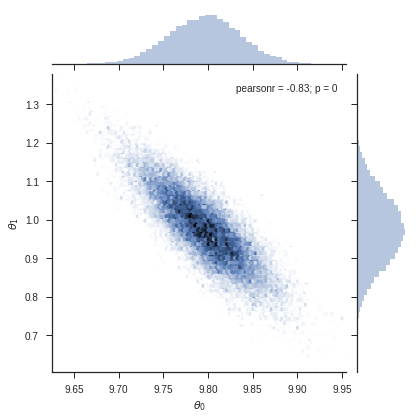

In [94]:
import pandas as pd
columns = [r'$\theta_{0}$'.format(i) for i in range(3)]
df_2D = pd.DataFrame(trace_2D, columns=columns[:2])

with sns.axes_style('ticks'):
    jointplot = sns.jointplot(r'$\theta_0$', r'$\theta_1$',
                              data=df_2D, kind="hex");

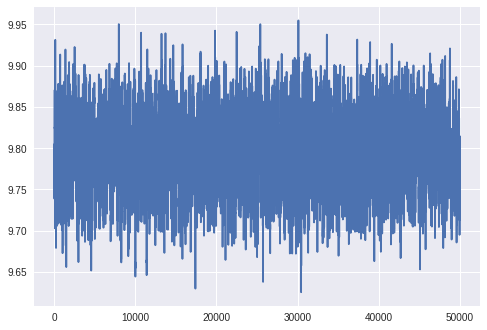

In [95]:
plt.plot(df_2D[r'$\theta_0$'])

In [ ]:

log_likelihood()

In [18]:
from scipy import integrate

def integrate_posterior_2D(log_posterior, xlim, ylim, data=data):
    func = lambda theta1, theta0: np.exp(log_posterior([theta0, theta1], data))
    return integrate.dblquad(func, xlim[0], xlim[1],
                             lambda x: ylim[0], lambda x: ylim[1])

In [19]:
df_2D.mean()

$\theta_0$   -0.202398
$\theta_1$    0.972743
dtype: float64

In [47]:
np.asarray(df_2D.mean())

array([-0.20239784,  0.97274278])

In [52]:
np.random.normal(polynomial_fit(np.asarray(df_2D.mean()),x),sigma_y)

array([ 0.22634226,  0.61857743, -0.21121691,  0.14397309, -0.00494243,
       -0.23454635, -0.02601103,  0.24412127,  0.23382435,  0.30830022,
        0.20204533,  0.67047164,  0.02599389,  0.70703725, -0.25240469,
        0.51811553,  0.27674388,  0.35665236,  0.04163264, -0.03530786])

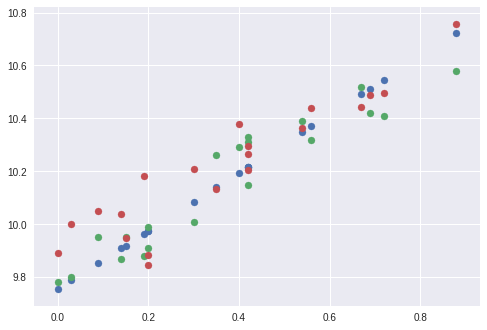

In [97]:
plt.scatter(x,polynomial_fit(np.asarray(df_2D.iloc[0]),x))
plt.scatter(x,y)
plt.scatter(x,np.random.normal(polynomial_fit(np.asarray(df_2D.iloc[0]),x),sigma_y))

In [113]:
discs=[]
disco=[]
for i in range(len(df_2D)//10):
    ysim=polynomial_fit(np.asarray(df_2D.iloc[i]),x)
    yexp=np.random.normal(polynomial_fit(np.asarray(df_2D.iloc[i]),x),sigma_y)
    discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()]
    disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()]

In [124]:
discs=np.array(discs)
disco=np.array(disco)

(0, 0.018880597339690799)

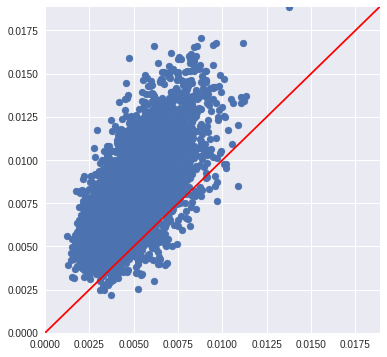

In [125]:
plt.figure(figsize=(6,6))

plt.scatter(discs,disco)
dmax=np.max(np.hstack((disco,discs)))
ppp=np.linspace(0,dmax,2)
plt.plot(ppp,ppp,c='r')
plt.xlim(0,dmax)
plt.ylim(0,dmax)

In [126]:
print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))

Bayesian p-value: 0.0378


In [172]:
~False

-1